In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class ec_reaction:
    def __init__(
        self,
        edft,
        zpe,
        reactants,
        labels,
        elchem_steps,
        electrode,
        eq_pot,
        tds=None,
        dg=None,
        symfac=1,
        refel="RHE"
    ):
        
        # placeholder reminder that multiple checks are necessary
        if len({len(edft), len(zpe), len(labels)-2, len(elchem_steps)-1}) != 1:
            raise ValueError("Mismatch in number of supplied elements")
        
        self.edft = edft
        self.zpe = zpe
        self.tds = [0] * len(self.edft) if tds is None else tds
        self.reactants = reactants
        self.labels = labels
        self.elchem_steps = elchem_steps
        self.electrode = electrode
        self.eq_pot = eq_pot
        
        self.symfac = symfac
        self.refel = refel
        
        if dg is None:
            self.dg = self._calc_dg_zero(self.edft, self.zpe, self.tds, self.reactants, self.symfac)
        else:
            self.dg = dg
        
    @classmethod
    def auto_read(cls):
        # read from subdirectories from a given directory. subdirectory names are deduced from labels
        pass
    
    @classmethod
    def from_dg(cls, dg):
        # probably not necessary
        pass
    
    def _sum_reactants(self, reactants, idx, energy_type):
        out = 0
        for key in reactants.keys():
            out += reactants[key]["reac_part"][idx] * reactants[key]["energies"][energy_type]
        return out
            
    
    def _calc_dg_zero(self, edft, zpe, tds, reactants, symfac):
        dg = []
        edft.insert(0, 0)
        zpe.insert(0, 0)
        tds.insert(0, 0)
        for i in range(1, len(edft)):
            de = edft[i] - edft[i-1] + symfac * self._sum_reactants(reactants, i-1, 0)
            dzpe = zpe[i] - zpe[i-1] + symfac * self._sum_reactants(reactants, i-1, 1)
            dtds = tds[i] - tds[i-1] + symfac * self._sum_reactants(reactants, i-1, 2)
            dg.append((de + dzpe - dtds) / symfac)
                                
        dg.append(self.eq_pot*sum(self.elchem_steps) - sum(dg))
        
        return dg
    
    def calc_gmax(self, op):
        dg = np.array(self.dg)

        dg = dg + self.electrode * (self.eq_pot + op)
        
        gmax = []
        for i in range(len(dg)):
            gmax.append(np.cumsum(dg[i:]))

        gmax_arr = np.concatenate(gmax)

        position_matrix = []
        for i in range(len(dg)):
            for j in range(len(dg)-i):
                position_matrix.append([i, j+i+1])

        gmax = max(gmax_arr)
        
        gmax_position = position_matrix[np.argmax(gmax_arr)]
        
        return (gmax, gmax_position)
    
    
    def calc_eta_td(self):
        dg = np.array(self.dg)
        eta_td = max(dg) + self.electrode * (self.eq_pot)
        eta_td_position = np.argmax(dg) + 1
        return (eta_td, eta_td_position)
    
    def _g_plot(self, dg_plot, u, print_labels=False, ax=None, **kwargs):

        ax = plt.gca() if ax is None else ax

        right_side = ax.spines["right"]
        top_side = ax.spines["top"]
        right_side.set_visible(False)
        top_side.set_visible(False)

        ax.set_xticks([])
        ax.set_xlim(0, sum(self.elchem_steps)+1.5)
        ax.set_ylabel('Free Energy, eV')
        ax.set_xlabel('Reaction Coordinate')

        ax.step(np.array(range(len(dg_plot))), dg_plot, where='post', **kwargs)

        ax.text(
            0.95, -0.01,
            rf'$U_\mathrm{{{self.refel}}}=${u:.2f} V',
            verticalalignment='top',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='k', fontsize=12)

        if print_labels:
            for i in range(len(self.labels)):
                ax.text(
                    i + 0.05,
                    dg_plot[i],
                    self.labels[i],
                    fontdict=None,
                    va='bottom',
                    rotation = 0,
                    size = 12)
                
    def _g_plot_trapezo(
        self,
        dg_plot,
        u,
        print_labels=False,
        ax=None,
        color='pink',
        line_width=0.85,
        **kwargs
    ):
        
        #some duplication of the code from _g_plot, perhaps can be improved / streamlined
        line_shift = 1-line_width
        
        ax = plt.gca() if ax is None else ax
        dg_plot = dg_plot[:-1]
        for i in range(len(dg_plot)):
            ax.plot([i+line_shift, i+line_width], [dg_plot[i], dg_plot[i]], color=color, **kwargs)
            
            if i > 0:
                ax.plot(
                    [i-line_shift, i+line_shift],
                    [dg_plot[i-1], dg_plot[i]],
                    linestyle='dotted',
                    color=color,
                    **kwargs
                )
                
            if print_labels:
                ax.text(
                    i + line_shift+0.05,
                    dg_plot[i],
                    self.labels[i],
                    fontdict=None,
                    va='bottom',
                    rotation = 0,
                    size = 12
                )
                
        right_side = ax.spines["right"]
        top_side = ax.spines["top"]
        right_side.set_visible(False)
        top_side.set_visible(False)

        ax.set_xticks([])
        ax.set_xlim(0, sum(self.elchem_steps)+1.5)
        ax.set_ylabel('Free Energy, eV')
        ax.set_xlabel('Reaction Coordinate')
        ax.text(
            0.95, -0.01,
            rf'$U_\mathrm{{{self.refel}}}=${u:.2f} V',
            verticalalignment='top',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='k', fontsize=12
        )
    

                
    def _g_transform_plot(self, dg, u):
        dg = np.array(dg)
        dg = dg - u
        dg_plot = np.cumsum(dg)
        dg_plot = np.concatenate(([0], dg_plot, [dg_plot[-1]]))
        return dg_plot
                
    def g_plot(self, dg=None, u=0, ax=None, trapezo=False, **kwargs):
        dg = self.dg if dg is None else dg
        ax = plt.gca() if ax is None else ax

        dg_plot = self._g_transform_plot(dg, u)
        
        if trapezo:
            self._g_plot_trapezo(dg_plot, u, **kwargs)
        else:
            self._g_plot(dg_plot, u, **kwargs)

        
    def g_plot_eq(self, ax=None, trapezo=False, **kwargs):
        ax = plt.gca() if ax is None else ax
        
        dg_plot = self._g_transform_plot(self.dg, u=self.eq_pot)
        
        if trapezo:
            self._g_plot_trapezo(dg_plot, u=self.eq_pot, print_labels=True, ax=ax, **kwargs)
        else:
            self._g_plot(dg_plot, u=self.eq_pot, print_labels=True, ax=ax, **kwargs)
        
        eta_td, eta_td_position = self.calc_eta_td()

        ax.text(
            eta_td_position + 0.27,
            (dg_plot[eta_td_position-1] + dg_plot[eta_td_position])/2,
            rf'$\eta_\mathrm{{TD}} = $ {eta_td:.2f} V',
            fontdict=None,
            va='center',
            rotation = 270,
            size=12
        )

        ax.annotate(
            '',
            xy=(eta_td_position + 0.25, dg_plot[eta_td_position]),
            xytext=(eta_td_position + 0.25, dg_plot[eta_td_position-1]),
            arrowprops={'arrowstyle':'<->', 'shrinkA': 0, 'shrinkB': 0}
        )
        
    
    def g_plot_gmax(self, op=0.3, ax=None, custom_coord=None, trapezo=False, **kwargs):
            
        ax = plt.gca() if ax is None else ax
        
        dg_plot = self._g_transform_plot(self.dg, u=(self.eq_pot + op))
        
        if trapezo:
            self._g_plot_trapezo(dg_plot, u=self.eq_pot, print_labels=True, ax=ax, **kwargs)
        else:
            self._g_plot(dg_plot, u=self.eq_pot, print_labels=True, ax=ax, **kwargs)
        
        gmax, pos = self.calc_gmax(op)

        ax.annotate(
            '',
            xy=(pos[1] + 0.25, dg_plot[pos[1]]),
            xytext=(pos[1] + 0.25, dg_plot[pos[0]]),
            arrowprops={'arrowstyle':'<->', 'shrinkA': 0, 'shrinkB': 0}
        )
        
        xytext_coord = (3, -1*op) if custom_coord is None else custom_coord
        
        ax.annotate(
            rf'$G_{{max}}$({op:.2f} V) =  {gmax:.2f} eV',
            xy = ( pos[1] + 0.25, (dg_plot[pos[1]] + dg_plot[pos[0]])/2 ),
            xytext = xytext_coord, ### this needs to be optimized
            arrowprops={
                'arrowstyle': '->',
                'shrinkA': 3,
                'shrinkB': 3,
                'connectionstyle':"arc3,rad=0.4",
                'ls': '--',
                'color': 'grey',
                'alpha': 0.5
            }
        )

In [3]:
class oer(ec_reaction):
    def __init__(
        self,
        edft,
        zpe,
        reactants_energies,
        labels=["*", "*OH", "*O", "*OOH", r"* + O$_2$"],
        elchem_steps=[True, True, True, True],
        electrode=-1,
        eq_pot=1.23,
        **kwargs
    ):
        
        self._check_reactants(reactants_energies)
        
        self.reactants={
            "*": {"reac_part": [-1, 0, 0]}, 
            "H2O": {"reac_part": [-1, 0, -1]},
            "H2": {"reac_part": [0.5, 0.5, 0.5]}
        }

        for key in self.reactants.keys():
            self.reactants[key]["energies"] = reactants_energies[key]
        
        super().__init__(edft, zpe, self.reactants, labels, elchem_steps, electrode, eq_pot, **kwargs)
        
    def _check_reactants(self, reactants):
        pass

    


In [4]:
def construct_ec_mechanism(reactants, labels, elchem_steps, electrode, eq_pot, **kwargs):
    
    class custom_ec_mechanism(ec_reaction):
        def __init__(
            self,
            edft,
            zpe,
            reactants_energies,
            reactants=reactants,
            labels=labels,
            elchem_steps=elchem_steps,
            electrode=electrode,
            eq_pot=eq_pot,
            **kwargs
        ):
            
            self.reactants = reactants
            for key in self.reactants.keys():
                self.reactants[key]["energies"] = reactants_energies[key]
            
            super().__init__(edft, zpe, reactants, labels, elchem_steps, electrode, eq_pot, **kwargs)
            self._check_reactants()
        
        def _check_reactants(self):
            pass
            
    return custom_ec_mechanism

def construct_ec_own(ec_reaction_class, reactants_energies, **kwargs):
    class ec_own(ec_reaction_class):
        def __init__(self, edft, zpe, reactants_energies=reactants_energies, **kwargs):
            super().__init__(edft, zpe, reactants_energies, **kwargs)
            
    return ec_own
            
        

In [5]:
### testing inheritance method
pentlandites_oer_inheritance = construct_ec_own(
    oer,
    {
        "*": [-1098.84651015, 7.7699320, 0],
        "H2O": [-14.19697643, 0.56792, 0.67],
        "H2": [-7.00151164, 0.26849, 0.403]
    }
)

test_inheritance = pentlandites_oer_inheritance(
    edft=[-1109.62562690, -1104.34057779, -1113.49315426],
    zpe=[8.2053904, 7.922305, 8.2315381],
    symfac=1,
    dg=None
)

In [6]:
### testing factory method
oer_factory = construct_ec_mechanism(
    reactants={
        "*": {"reac_part": [-1, 0, 0]},
        "H2O": {"reac_part": [-1, 0, -1]},
        "H2": {"reac_part": [0.5, 0.5, 0.5]}
    },
    labels=["*", "*OH", "*O", "*OOH", r"* + O$_2$"],
    elchem_steps=[True, True, True, True],
    electrode=-1,
    eq_pot=1.23
)

pentlandites_oer_factory = construct_ec_own(
    oer_factory,
    {
        "*": [-1098.84651015, 7.7699320, 0],
        "H2O": [-14.19697643, 0.56792, 0.67],
        "H2": [-7.00151164, 0.26849, 0.403]
    }
)

test_factory = pentlandites_oer_factory(
    edft=[-1109.62562690, -1104.34057779, -1113.49315426],
    zpe=[8.2053904, 7.922305, 8.2315381],
    symfac=1, dg=None
)




In [7]:
print(test_factory.reactants)

print(test_inheritance.reactants)

print(f"factory dg: {test_factory.dg}\n")

print(f"inheritance dg:{test_inheritance.dg}\n")

print(f"gmax factory is: {test_factory.calc_gmax(op = 0.30)}\n")

print(f"gmax inheritance is: {test_inheritance.calc_gmax(op = 0.30)}\n")

{'*': {'reac_part': [-1, 0, 0], 'energies': [-1098.84651015, 7.769932, 0]}, 'H2O': {'reac_part': [-1, 0, -1], 'energies': [-14.19697643, 0.56792, 0.67]}, 'H2': {'reac_part': [0.5, 0.5, 0.5], 'energies': [-7.00151164, 0.26849, 0.403]}}
{'*': {'reac_part': [-1, 0, 0], 'energies': [-1098.84651015, 7.769932, 0]}, 'H2O': {'reac_part': [-1, 0, -1], 'energies': [-14.19697643, 0.56792, 0.67]}, 'H2': {'reac_part': [0.5, 0.5, 0.5], 'energies': [-7.00151164, 0.26849, 0.403]}}
factory dg: [0.38738725999999823, 1.4339528900000442, 1.887702240000014, 1.2109576099999435]

inheritance dg:[0.38738725999999823, 1.4339528900000442, 1.887702240000014, 1.2109576099999435]

gmax factory is: (0.35770224000001405, [2, 3])

gmax inheritance is: (0.35770224000001405, [2, 3])



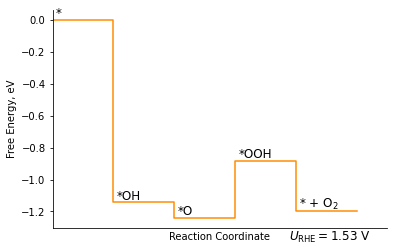

In [8]:
fig, ax = plt.subplots()
test_factory.g_plot(u = 1.53, print_labels=True, c="darkorange")

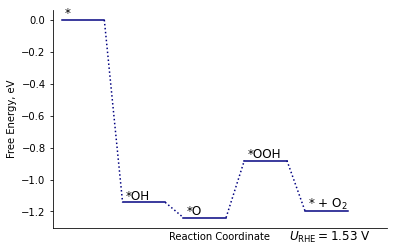

In [9]:
fig, ax = plt.subplots()
test_factory.g_plot(u = 1.53, trapezo=True, print_labels=True, color="navy", line_width=0.85)

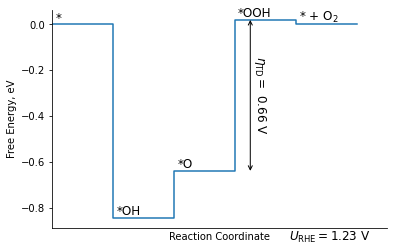

In [10]:
fig, ax = plt.subplots()
test_factory.g_plot_eq()

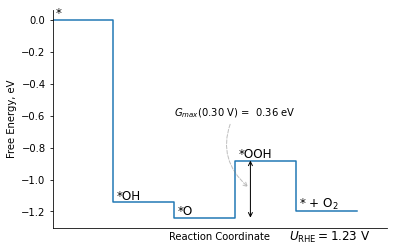

In [11]:
test_factory.g_plot_gmax(custom_coord=(2, -0.6))

(5.172229999999992, [1, 4])


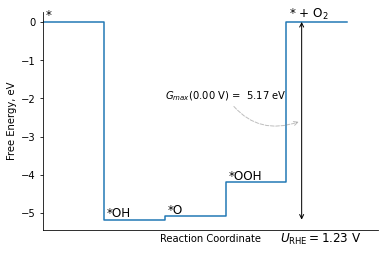

In [12]:
test_mxenes_cls = construct_ec_own(
    oer_factory,
    {
        "*": [-322.3571, 0, 0],
        "H2O": [-14.21547, 0.566, 0.67],
        "H2": [-6.7547, 0.2677, 0.41]
    }
)

test_mxenes_oer = test_mxenes_cls(
    edft=[-337.1703,  -332.402, -341.1524],
    zpe=[0, 0, 0],
    symfac=1, dg=None
)

test_mxenes_oer_2 = test_mxenes_cls(
    edft=[-337.1703,  -332.402, -341.1524],
    zpe=[0, 0, 0]
)

test_mxenes_oer.g_plot_gmax(op=0, custom_coord=(2, -2))
print(test_mxenes_oer.calc_gmax(op=0))

[0, 0, 0]


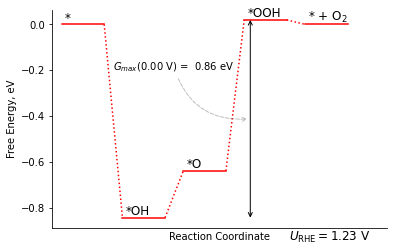

In [17]:
test_mxenes_oer_3 = test_mxenes_cls(
    edft=[0, 0, 0],
    zpe=[0, 0, 0],
    dg=test_mxenes_oer_2.dg
)
test_factory.g_plot_gmax(op=0, custom_coord=(1, -0.2), trapezo=True, color='red')
print(test_mxenes_oer_3.edft)